Main hypothesis: Banks (morgages) fuel house price increase

Exploring: the feedback loop between credit expansion, inequality, and housing prices with an emphasis on whether rising mortgage volumes reflect not just inflation but changing financial behavior and structural inequality

Over time, loans have increased, not only due to inflation?
1. Idea: Banks are doing bigger risks because they can just own the property after the borrower defaults -> taking away resources -> bigger battle for resources -> price increase -> loans increase because wages didn’t increase
-> Formulate a relationship between morgages, inequality and housing price

Key Variables:

- Housing Prices
- Mortgage Credit
- Interes Rates
- Wages/Income
- Inequality
- Inflation
- Housing Supply


Real House Price = nominal house price / CPI
Real Mortgage Credit = mortgage credit / CPI
Mortgage-to-Income Ratio = total mortgage credit / disposable personal income
Debt-Service Ratio = mortgage payments / income
Housing Affordability Index = function of income, rates, and home prices

In [41]:
import pandas as pd
from pathlib import Path

data_path = Path("data")

# Read the 'Monthly' sheet from the median_house_price file
prices = pd.read_excel(data_path / "median_house_price.xlsx", sheet_name="Monthly")
# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(prices["observation_date"]):
    prices["observation_date"] = pd.to_datetime(prices["observation_date"])

prices.set_axis(prices["observation_date"], inplace=True)  # index by date
# Read CPI file and parse dates; adjust column name if different
cpi_data = pd.read_excel(
    data_path / "cpi.xlsx",
    sheet_name="Monthly",
    parse_dates=["observation_date"]  # ensure this is the actual date column name
)

# Ensure the date column is datetime
if not pd.api.types.is_datetime64_any_dtype(cpi_data["observation_date"]):
    cpi_data["observation_date"] = pd.to_datetime(cpi_data["observation_date"])

# Filter CPI data to start from 1963-01-01 (inclusive)
cpi_data = cpi_data[cpi_data["observation_date"] >= "1963-01-01"]

# Extract CPI series (column named 'cpi' in the Excel file)
cpi = cpi_data["cpi"]

# Optional: reset index or keep dates as index
cpi = cpi.set_axis(cpi_data["observation_date"])  # index by date if desired

# Quick check
print(cpi.head())
print(f"Rows after filtering: {len(cpi)}")

TypeError: DataFrame.set_axis() got an unexpected keyword argument 'inplace'

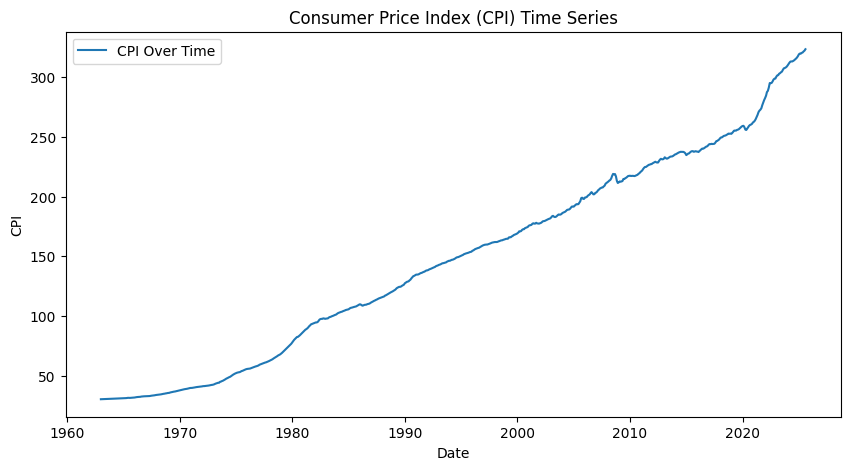

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(cpi.index, cpi.values, label='CPI Over Time')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Consumer Price Index (CPI) Time Series')
plt.legend()
plt.show()



<Figure size 640x480 with 0 Axes>

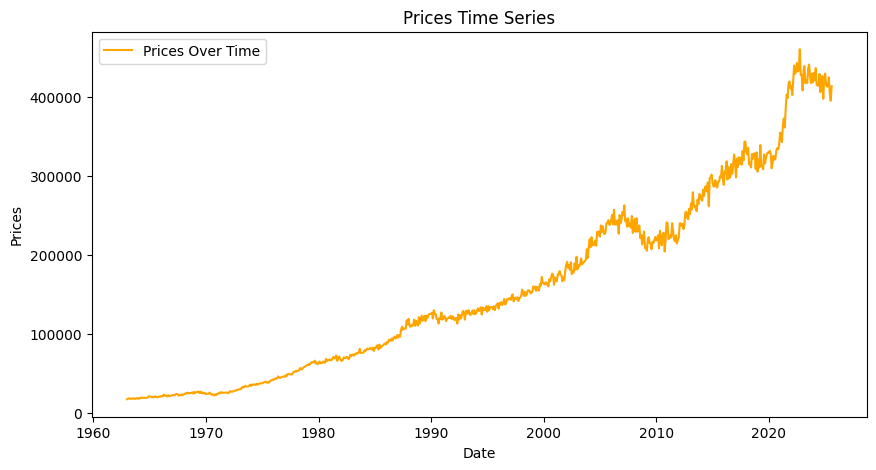

In [ ]:
# clear last plot
plt.clf()
# plot nominal prices
plt.figure(figsize=(10, 5))
plt.plot(prices.index, prices.price, label='Prices Over Time', color='orange')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title('Prices Time Series')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

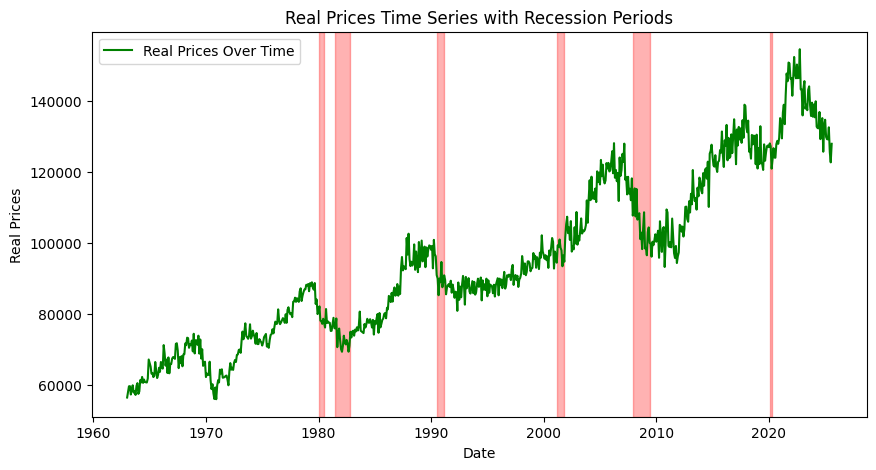

In [ ]:

cpi_100 = cpi / 100

real_prices = prices.price.values / cpi_100.values  # Align CPI to prices index

# plot recession periods
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(prices.observation_date, real_prices, label='Real Prices Over Time',color='green')
# Highlight recession periods
recession_periods = [
    ("1980-01-01", "1980-07-01"),  # Early 1980s recession
    ("1981-07-01", "1982-11-01"),  # Double-dip recession
    ("1990-07-01", "1991-03-01"),  # Early 1990s recession
    ("2001-03-01", "2001-11-01"),  # Dot-com recession
    ("2007-12-01", "2009-06-01"),  # Great Recession
    ("2020-02-01", "2020-04-01")   # COVID-19 recession
]
for start, end in recession_periods:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.3) # Highlight recession periods
plt.xlabel('Date')
plt.ylabel('Real Prices')
plt.title('Real Prices Time Series with Recession Periods')
plt.legend()
plt.show()  

In [60]:
# log transform
import numpy as np
log_real_prices = np.log(real_prices)

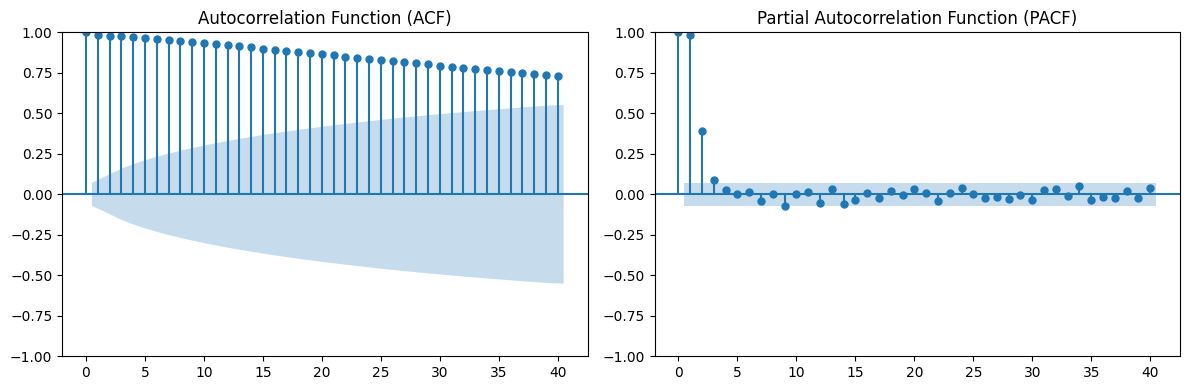

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Basic ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(log_real_prices, lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(log_real_prices, lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [62]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(p, d, q) where:
# p = AR lags (2 in your case)
# d = differencing order (0 if your data is already stationary)
# q = MA terms (0 for no MA)

model = ARIMA(log_real_prices, order=(2, 0, 0))
results = model.fit()

# View results
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  752
Model:                 ARIMA(2, 0, 0)   Log Likelihood                1497.337
Date:                Tue, 11 Nov 2025   AIC                          -2986.674
Time:                        13:04:49   BIC                          -2968.183
Sample:                             0   HQIC                         -2979.550
                                - 752                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4326      0.099    114.958      0.000      11.238      11.628
ar.L1          0.4976      0.030     16.844      0.000       0.440       0.556
ar.L2          0.4940      0.030     16.649      0.0

[1.14326100e+01 4.97642861e-01 4.93979399e-01 1.08574549e-03]


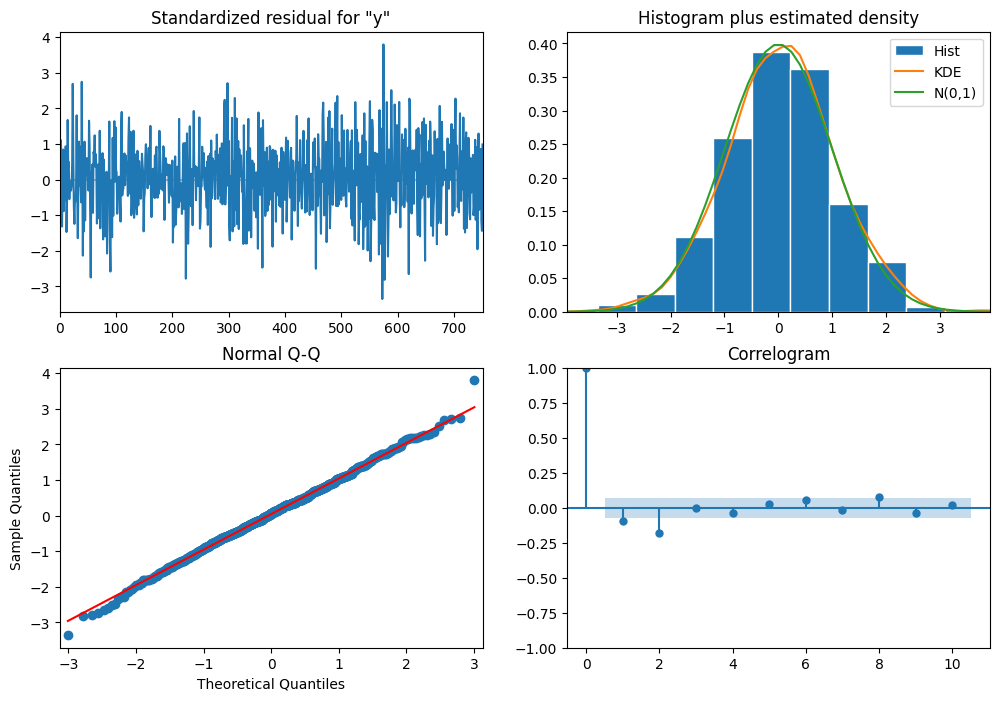

In [63]:
# Fitted values
fitted_values = results.fittedvalues

# Residuals
residuals = results.resid

# Forecasting
forecast = results.forecast(steps=10)

# Model parameters
print(results.params)

# Plot diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()

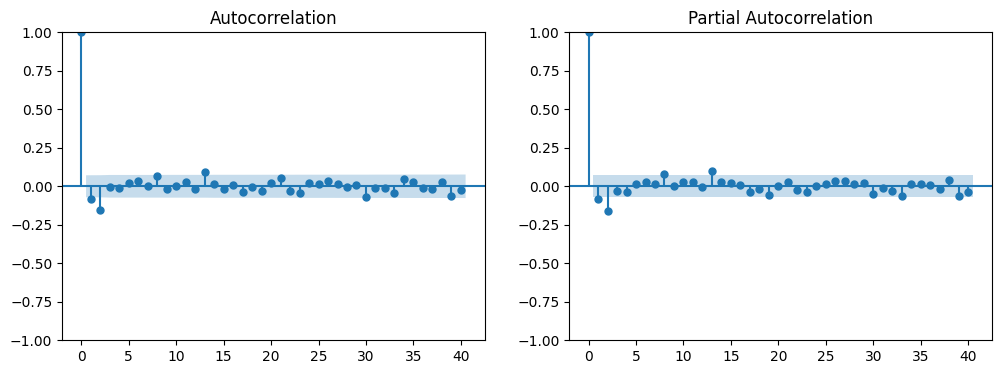

In [65]:
# After fitting a model
residuals = results.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, lags=40, ax=axes[0])
plot_pacf(residuals, lags=40, ax=axes[1])
plt.show()

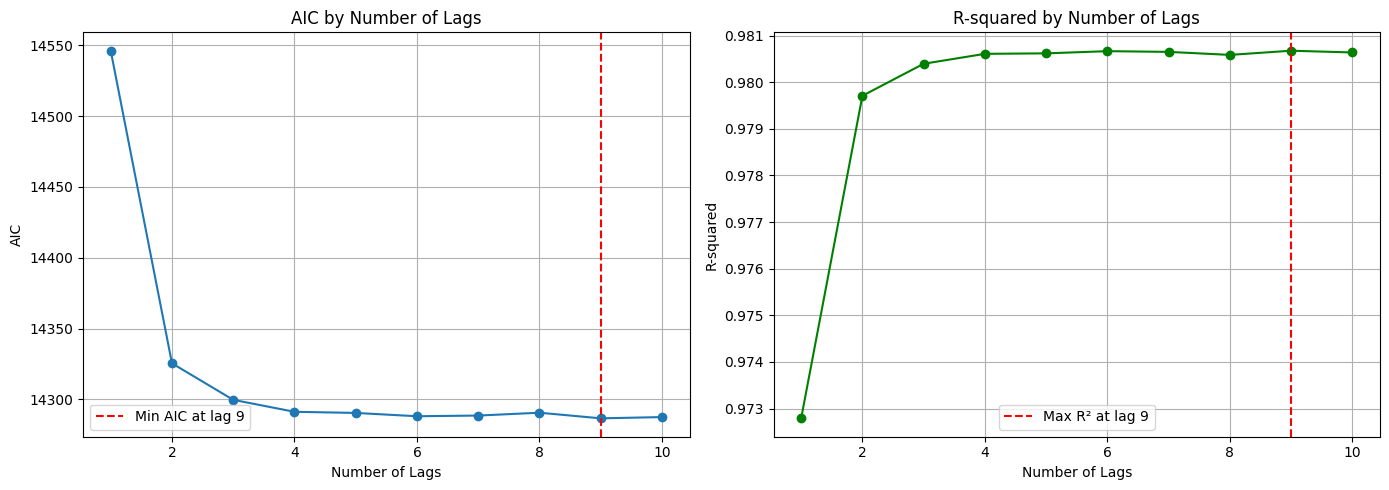

Best lag by AIC: 9 (AIC = 14286.61)
Best lag by R²: 9 (R² = 0.9807)


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import numpy as np

# Test different lag orders
max_lags = 10
aic_values = []
rsq_values = []
lags = range(1, max_lags + 1)

for p in lags:
    model = ARIMA(real_prices, order=(p, 0, 0))
    results = model.fit()
    aic_values.append(results.aic)
    
    # R-squared (calculate manually for ARIMA)
    fitted = results.fittedvalues
    ss_res = np.sum((real_prices[p:] - fitted[p:]) ** 2)
    ss_tot = np.sum((real_prices[p:] - np.mean(real_prices[p:])) ** 2)
    rsq = 1 - (ss_res / ss_tot)
    rsq_values.append(rsq)

# Plot AIC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(lags, aic_values, marker='o')
axes[0].set_xlabel('Number of Lags')
axes[0].set_ylabel('AIC')
axes[0].set_title('AIC by Number of Lags')
axes[0].grid(True)
# Mark the minimum
min_aic_lag = lags[np.argmin(aic_values)]
axes[0].axvline(min_aic_lag, color='red', linestyle='--', label=f'Min AIC at lag {min_aic_lag}')
axes[0].legend()

# Plot R-squared
axes[1].plot(lags, rsq_values, marker='o', color='green')
axes[1].set_xlabel('Number of Lags')
axes[1].set_ylabel('R-squared')
axes[1].set_title('R-squared by Number of Lags')
axes[1].grid(True)
# Mark the maximum
max_rsq_lag = lags[np.argmax(rsq_values)]
axes[1].axvline(max_rsq_lag, color='red', linestyle='--', label=f'Max R² at lag {max_rsq_lag}')
axes[1].legend()

plt.tight_layout()
plt.show()
